In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/FinalWork

/content/drive/MyDrive/FinalWork


In [11]:
import tensorflow as tf
import PIL
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)
from tensorflow.keras.applications import mobilenet as _mobilenet
import random
import os
import numpy as np
from PIL import Image
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from IPython.display import Image as iImage
from IPython.display import display
import math

In [4]:
def normalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    normalised_p = (p-min_d)/(max_d - min_d)
    return normalised_p

def denormalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    denormalised_p = p * (max_d - min_d) + min_d
    return denormalised_p

In [8]:
# Return the (g,h) index of the BMU in the grid
def find_BMU(SOM,x):
    distSq = (np.square(SOM - x)).sum(axis=2)
    return np.unravel_index(np.argmin(distSq, axis=None), distSq.shape)

# Return the (g,h) index of the BMU in the grid
def find_BMU_2(SOM,x):
    distSq = (np.square(SOM - x)).sum(axis=2)
    return np.unravel_index(np.argpartition(distSq, 2, axis=None)[2], distSq.shape)

# Update the weights of the SOM cells when given a single training example
# and the model parameters along with BMU coordinates as a tuple
def update_weights(SOM, train_ex, learn_rate, radius_sq,
                   BMU_coord, step=3):
    g, h = BMU_coord
    #if radius is close to zero then only BMU is changed
    if radius_sq < 1e-3:
        SOM[g,h,:] += learn_rate * (train_ex - SOM[g,h,:])
        return SOM
    # Change all cells in a small neighborhood of BMU
    for i in range(max(0, g-step), min(SOM.shape[0], g+step)):
        for j in range(max(0, h-step), min(SOM.shape[1], h+step)):
            dist_sq = np.square(i - g) + np.square(j - h)
            dist_func = np.exp(-dist_sq / 2 / radius_sq)
            SOM[i,j,:] += learn_rate * dist_func * (train_ex - SOM[i,j,:])
    return SOM

# Main routine for training an SOM. It requires an initialized SOM grid
# or a partially trained grid as parameter
def train_SOM(SOM, train_data, learn_rate = .1, radius_sq = 1,
             lr_decay = .1, radius_decay = .1, epochs = 10):
    learn_rate_0 = learn_rate
    radius_0 = radius_sq
    for epoch in np.arange(0, epochs):
        rand.shuffle(train_data)
        for train_ex in train_data:
            g, h = find_BMU(SOM, train_ex)
            SOM = update_weights(SOM, train_ex,
                                 learn_rate, radius_sq, (g,h))
        # Update learning rate and radius
        learn_rate = learn_rate_0 * np.exp(-epoch * lr_decay)
        radius_sq = radius_0 * np.exp(-epoch * radius_decay)
    return SOM

In [7]:
import scipy
def calculateQE(SOM,data):
    sumSqDist = 0
    for d in data:
        g,h = find_BMU(SOM, d)
        v1 = SOM[g,h]
        v2 = d
        sumSqDist += scipy.spatial.distance.cdist([v1],[v2],'sqeuclidean')[0][0]
    QE = sumSqDist/len(data)
    return QE

def calculateTE(SOM,data):
    failed = 0
    for d in data:
        g1,h1 = find_BMU(SOM,d)
        g2,h2 = find_BMU_2(SOM,d)
        dist = scipy.spatial.distance.cityblock([g1,h1], [g2,h2])
        if dist>1:
            failed+=1
    return failed/len(data)

In [9]:
import sklearn
#这段代码实现了计算自组织映射（SOM）训练后的网络的U-矩阵（U-matrix）。U-矩阵是一种可视化工具，用于显示SOM中各单元之间的相似度
def euclidean(a, b):
    return np.linalg.norm(a-b)

def u_matrix(lattice):
    """Builds a U-matrix on top of the trained lattice.

        Parameters
        ---
        lattice : list

            The SOM generated lattice

        Returns
        ---
        The lattice of the shape (R,C):

        R - number of rows; C - number of columns;
        """
    X, Y, Z = lattice.shape
    u_values = np.empty((X,Y), dtype=np.float64)

    for y in range(Y):
        for x in range(X):
            current = lattice[x,y]
            dist = 0
            num_neigh = 0
            # left
            if x-1 >= 0:
                #middle
                vec = lattice[x-1,y]
                dist += euclidean(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #sup
                    vec = lattice[x-1, y-1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
                if y + 1 < Y:
                    # down
                    vec = lattice[x-1,y+1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
            # middle
            if y - 1 >= 0:
                # up
                vec = lattice[x,y-1]
                dist += euclidean(current, vec)
                num_neigh += 1
            # down
            if y + 1 < Y:
                vec = lattice[x,y+1]
                dist += euclidean(current, vec)
                num_neigh += 1
            # right
            if x + 1 < X:
                # middle
                vec = lattice[x+1,y]
                dist += euclidean(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #up
                    vec = lattice[x+1,y-1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
                if y + 1 < lattice.shape[1]:
                    # down
                    vec = lattice[x+1,y+1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
            u_values[x,y] = dist / num_neigh
    u_values = (u_values - 1) * -1
    return u_values

In [74]:
def activate(train_data, SOM, p):
    normalP = normalise(train_data, p)
    activatedSOM = np.array([[euclidean(normalP, c) for c in r] for r in SOM])
    normalisedActivatedSOM = normalise(activatedSOM, activatedSOM)
    activatedSOM = (normalisedActivatedSOM -1)*(-1)
    return activatedSOM


In [15]:
import json

def extract_text_from_json(file_path):
    text_data = []
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            json_data = json.load(file)
            for tweet in json_data['tweets']:
                text_data.append(tweet['text'])
    except Exception as e:
        print("Error processing file:", file_path)
        print("Error message:", str(e))

    return text_data

def extract_text_from_directory(directory_path):
    all_text_data = []
    for root, dirs, files in os.walk(directory_path):
        for file_name in files:
            if file_name.endswith('.json'):
                file_path = os.path.join(root, file_name)
                text_data = extract_text_from_json(file_path)
                all_text_data.extend(text_data)
    return all_text_data

directory_path = '/content/drive/MyDrive/FinalWork/comment/social group'
all_text_data = extract_text_from_directory(directory_path)


In [14]:
print("Number of sentences:", len(all_text_data))

Number of sentences: 16235


In [16]:
twitter_sentences = all_text_data[:]

In [ ]:
import re

# Define regex patterns for links and hashtags
link_pattern = r'https?://\S+'
hashtag_pattern = r'#\w+'

# Function to remove links and hashtags from text
def remove_links_and_hashtags(text):
    text = re.sub(link_pattern, '', text)
    text = re.sub(hashtag_pattern, '', text)
    return text

# Remove links and hashtags from each sentence
filtered_sentences = [remove_links_and_hashtags(sentence) for sentence in twitter_sentences]

# Remove empty sentences
filtered_sentences = [sentence for sentence in filtered_sentences if sentence.strip()]

In [ ]:
filtered_sentences

In [20]:
# 向量维度（vector_size）：

# 这个参数指定了每个文档（或句子）的向量表示的维度大小。在这个例子中，向量的维度被设置为 100，意味着每个句子最终都将由一个长度为 100 的向量表示。
# 窗口大小（window）：

# 这个参数定义了在训练过程中，模型在查看每个单词时所考虑的上下文单词的范围。具体来说，对于每个单词，模型将考虑其周围的 window 大小范围内的单词作为上下文信息。在这个例子中，窗口大小被设置为 5，表示模型将考虑每个单词周围 5 个单词的上下文信息。
# 最小词频（min_count）：

# 这个参数指定了训练过程中模型所考虑的词语的最小词频。具体来说，词频低于 min_count 的词语将被忽略，不会被纳入模型的训练中。在这个例子中，最小词频被设置为 1，意味着所有出现至少一次的词语都会被考虑在内。
# 并行处理线程数（workers）：

# 这个参数指定了在训练过程中用于并行处理的线程数。通过增加并行处理线程数，可以加速模型的训练过程。在这个例子中，设置了 4 个并行处理线程。

In [21]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import numpy as np

documents = [TaggedDocument(words=s.split(), tags=[str(i)]) for i, s in enumerate(filtered_sentences)]

# 使用 TaggedDocument 对象列表来训练 Doc2Vec 模型
doc2vec_model = Doc2Vec(documents, vector_size=150, window=5, min_count=1, workers=4)

sentence_vectors = [doc2vec_model.infer_vector(sentence.split()) for sentence in filtered_sentences]

In [28]:
featureTextPairs = []
for i in range(len(sentence_vectors)):
    featureText = {}
    featureText['sentence'] = filtered_sentences[i]
    featureText['feature'] = sentence_vectors[i]
    featureTextPairs.append(featureText)
print(len(featureTextPairs))

15556


In [29]:
featureTextPairs[1]

{'sentence': 'Host the topic  he & his team looked upon me with  Now Im   on  THEY      ttps://m.facebook.com/story.php?story_fbid=10213391799646773&id=1152752716a1',
 'feature': array([-1.87983550e-02,  2.41272454e-03, -4.73601604e-03, -3.82773648e-03,
         1.79120079e-02, -3.69933876e-03, -1.26612664e-03,  1.43815521e-02,
        -1.75590208e-03,  1.28620565e-02,  1.98117364e-02, -1.14593375e-03,
        -1.90858427e-03,  2.25519072e-02, -2.12073121e-02, -8.29110667e-03,
        -3.03460588e-03,  6.76168303e-04, -2.17625499e-02,  2.48125345e-02,
        -5.13176015e-03,  2.00598780e-03,  3.64358686e-02,  7.01590022e-03,
         7.37373484e-03,  3.14034484e-02,  7.84867094e-04, -1.90710276e-02,
        -2.11230828e-04, -4.58798185e-02,  1.98690984e-02, -2.09664814e-02,
         1.20074218e-02,  2.71977130e-02,  2.34819861e-04, -6.25398615e-03,
         2.29796488e-02,  2.45330099e-04, -1.33473016e-02, -2.74307709e-02,
         1.93039458e-02, -1.03565427e-02,  8.70927796e-03, -1.

In [33]:
# Dimensions of the SOM grid
m = 10
n = 25
# Number of training examples
n_x = 6000
rand = np.random.RandomState(0)
# Initialize the training data
train_data = sentence_vectors

# Normalised Training Data
n_train_data = normalise(train_data, train_data)

# Initialize the SOM randomly
SOM = rand.uniform(0, 1, (m, n, len(train_data[0])))

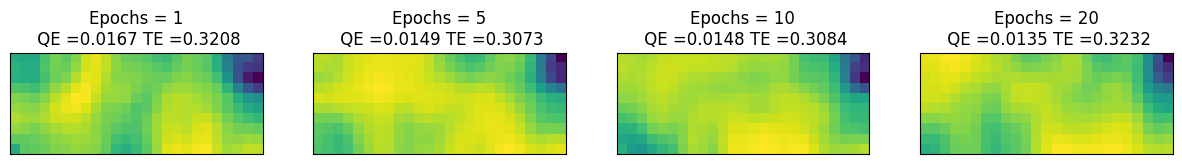

In [34]:
fig, ax = plt.subplots(
    nrows=1, ncols=4, figsize=(15, 3.5),
    subplot_kw=dict(xticks=[], yticks=[]))
total_epochs = 0
SOMS = []
for epochs, i in zip([1, 4, 5, 10], range(0,4)):
    total_epochs += epochs
    SOM = train_SOM(SOM, n_train_data, learn_rate = .1, radius_sq = 2, epochs = epochs)
    SOMS.append(SOM)
    QE = round(calculateQE(SOM, n_train_data), 4)
    TE = round(calculateTE(SOM, n_train_data), 4)

    ax[i].imshow(u_matrix(SOM))
    ax[i].title.set_text('Epochs = ' + str(total_epochs) + '\n QE =' + str(QE) + ' TE =' + str(TE))

In [35]:
SOM = SOMS[-1]

In [41]:
find_BMU(SOM, normalise(train_data,featureTextPairs[55]['feature']))

(2, 18)

In [52]:
bmu_index = find_BMU(SOM, normalise(train_data, featureTextPairs[11]['feature']))

best_match_contents = []

if isinstance(featureTextPairs[bmu_index[0] * SOM.shape[1] + bmu_index[1]], list):
    for content in featureTextPairs[bmu_index[0] * SOM.shape[1] + bmu_index[1]]:
        best_match_contents.append(content['sentence'])
else:
    best_match_contents.append(featureTextPairs[bmu_index[0] * SOM.shape[1] + bmu_index[1]]['sentence'])

print("index content:", featureTextPairs[11]['sentence'])
print("best matches:", best_match_contents)

index content: Muslim Honour Killing 2009. They Killed their 3 daughters in Kingston Ontario. The family said that they Betrayed Isam. @JustinTrudeau says this is not Barbaric!    
best matches: ['La supermodelo no da el motivo por el que acusa a Paul Marciano, sin embargo, muestra claramente su apoyo al movimiento . ENTÉRATE -->\xa0bit.ly/2s0G8UM ']


In [42]:
SOMimages = []
for i in range(len(SOM)):
    row = []
    for j in range(len(SOM[0])):
        row.append([])
    SOMimages.append(row)

In [44]:
for fi in featureTextPairs:
    g,h = find_BMU(SOM, normalise(train_data, fi['feature']))
    SOMimages[g][h].append(fi)

In [ ]:
[[len(c) for c in r] for r in SOMimages]

In [53]:
from scipy import spatial

imageGrid = []
for g in range(len(SOMimages)):
    row = SOMimages[g]
    for h in range(len(row)):
        cell = row[h]
        if len(cell) > 0:
            imageGrid.append(cell[0]['sentence'])
        else:
            imageGrid.append('white.png')

In [54]:
print(len(SOMimages))
print(len(SOMimages[0]))

10
25


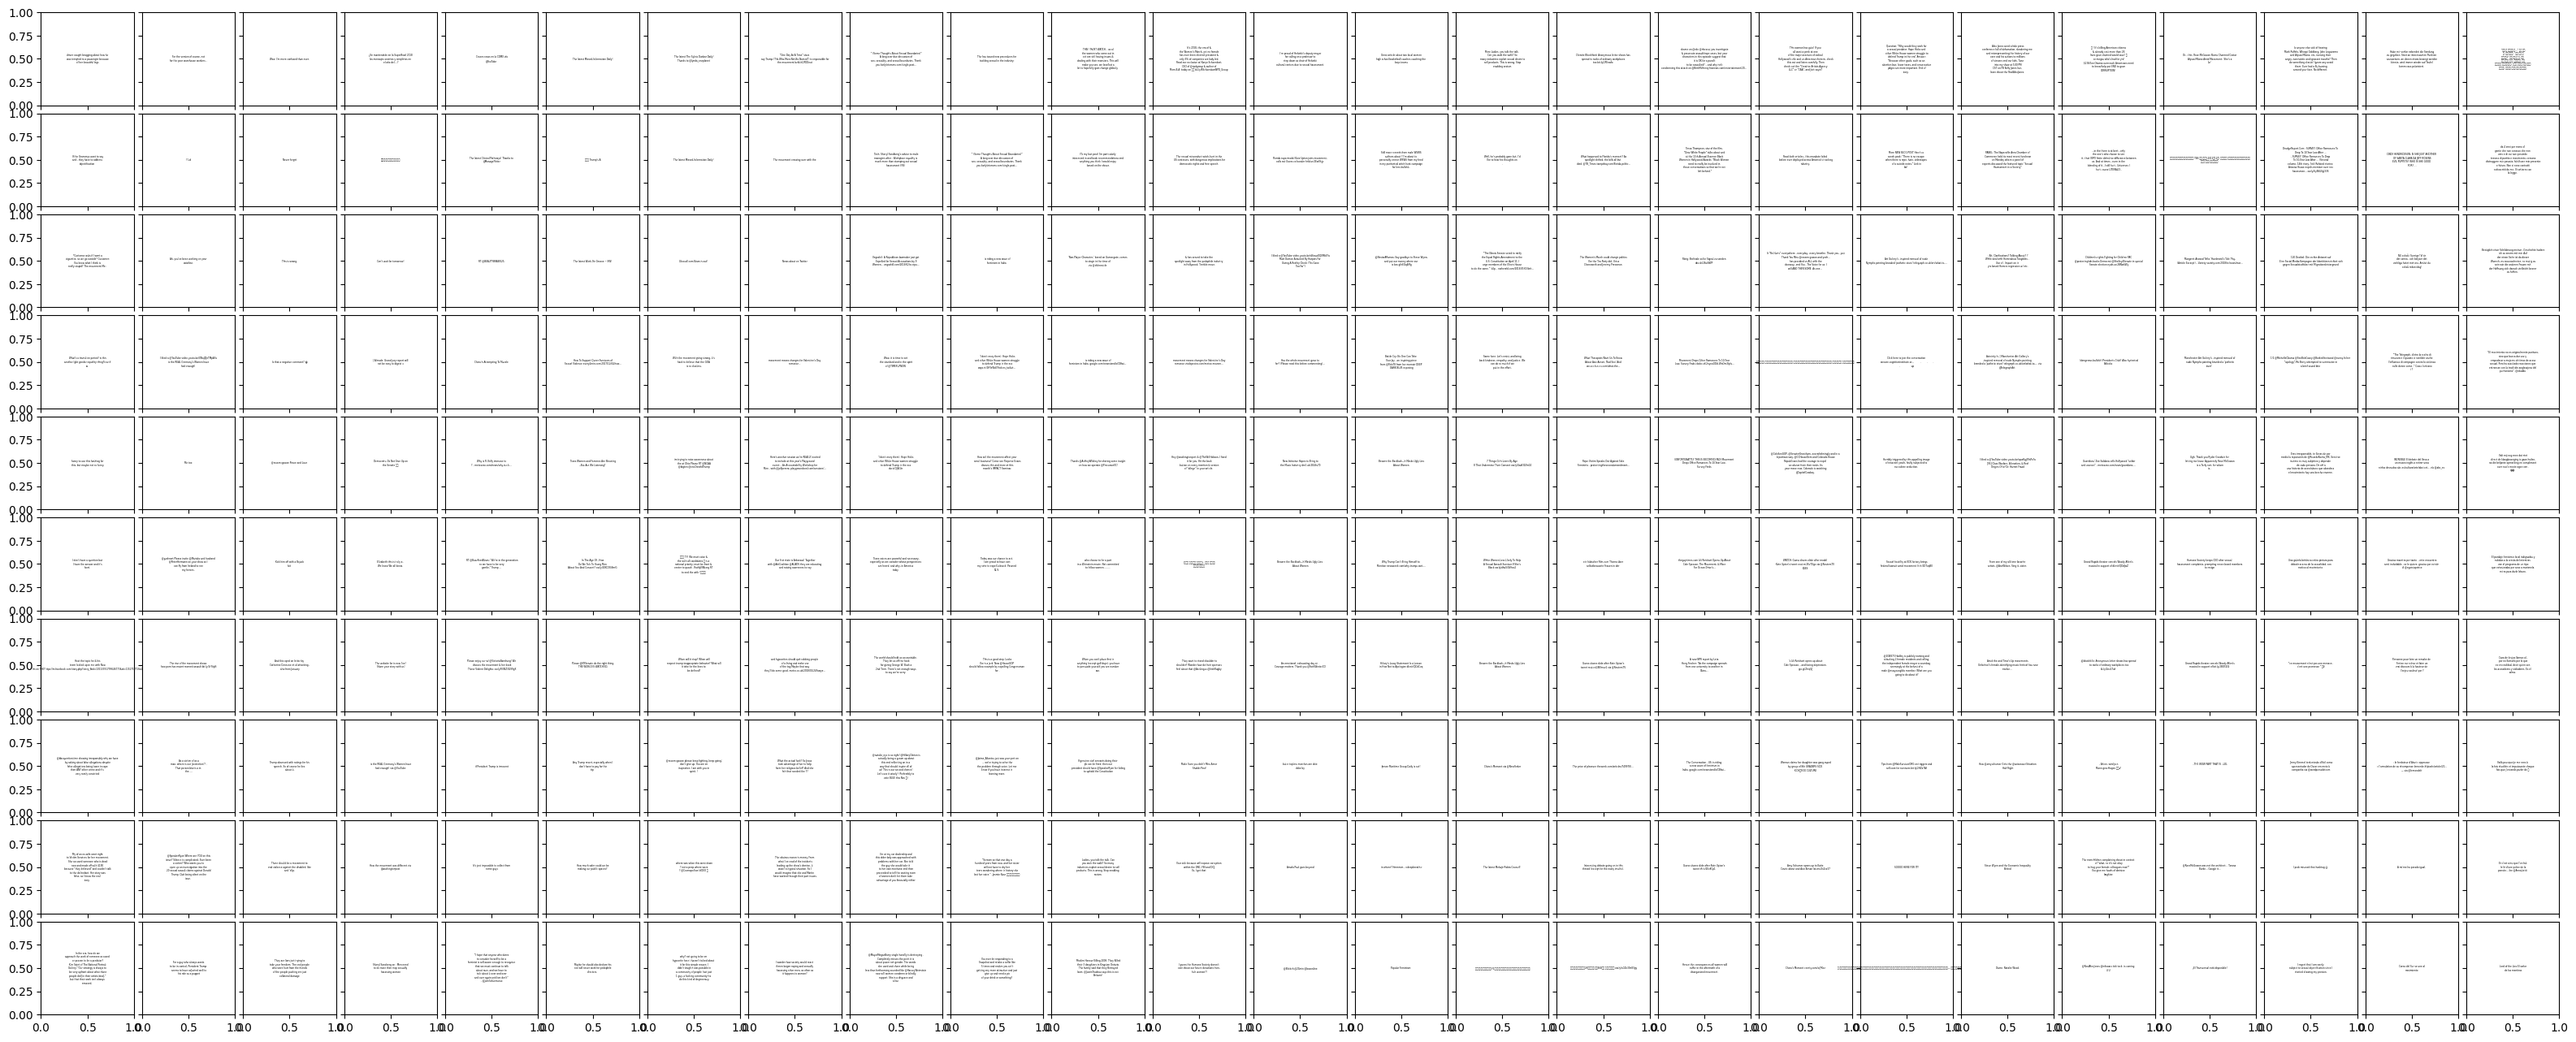

In [64]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# 指定每行的单词数量
words_per_line = 6

fig = plt.figure(figsize=(40, 20))  # 调整图形大小

grid = ImageGrid(fig, 111,
                 nrows_ncols=(m, n),  # 根据新的 SOM 尺寸设置行和列数
                 axes_pad=0.1,          # 指定单元格之间的间距
                 )

for i in range(m):
    for j in range(n):
        cell = SOMimages[i][j]
        if cell:
            sentence = cell[0]['sentence']
            # 使用 split() 方法将句子分割成单词列表
            words = sentence.split()
            # 将单词重新组合成多行文本，每行指定单词数量后换行
            lines = [' '.join(words[k:k+words_per_line]) for k in range(0, len(words), words_per_line)]
            # 使用换行符将多行文本组合成最终的句子
            formatted_sentence = '\n'.join(lines)
            grid[i * n + j].set_xlim(0, 1)
            grid[i * n + j].set_ylim(0, 1)
            grid[i * n + j].text(0.5, 0.5, formatted_sentence, va='center', ha='center', fontsize=2)  # 调整字体大小
        else:
            grid[i * n + j].text(0.5, 0.5, "", va='center', ha='center', fontsize=30)  # 调整字体大小

plt.show()


In [82]:
input_sentence = "eat foods after play sports"

# 使用 Doc2Vec 或其他方法向量化输入句子（这里使用假设的向量）
input_vector = doc2vec_model.infer_vector(input_sentence.split())

normalised_input_vector = normalise(train_data, input_vector)
bmu_index = find_BMU(SOM, normalised_input_vector)

# 获取与 BMU 匹配的所有句子
matched_sentences = []
for cell in SOMimages[bmu_index[0]][bmu_index[1]]:
    matched_sentences.append(cell['sentence'])

print("Your input sentence:", input_sentence)
print("Matched sentences from the BMU cell:")
for sentence in matched_sentences:
    print("-", sentence)


Your input sentence: eat foods after play sports
Matched sentences from the BMU cell:
-  is riding a new wave of feminism in India. google.com/newsstand/s/CBIwi…
- Politics forgot due process long before   via @ipoliticsca
- Gov. @dougducey waited until  after  expulsion to weigh in    
- "I don’t envy them": Hope Hicks and women in the White House struggle to defend Trump in the  era wapo.st/2F55BOP
- Guardians of the Galaxy's Zoe Saldana says Hollywood was "unfair and uneven" until  digitalspy.com/movies/guardi…
- Disgraced ex-BofA exec raises uncomfortable questions about   via @YahooFinance
-   "21stCenturyGirlZ™  gotta  have   "  iSurfMyPlatformZ™     +   ©calilili™  🌱🐚 🐬  🦀 of the   +    
- I love how these guys bury themselves  
- 's Tsai on brave women,  and self-confidence. Read more at  
-  Donald Trump's disgusting message to women       flip.it/iG-PuS
- (The Union-Tribune)  Trump's  actions are worse than his words : Like the Elton John concerts.. 
- Diocese: More than 20 a

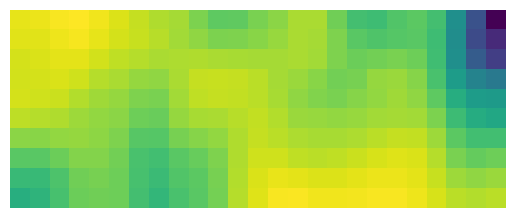

In [80]:
fig = plt.figure()
plt.imshow(u_matrix(SOM))
plt.axis('off')
plt.show()


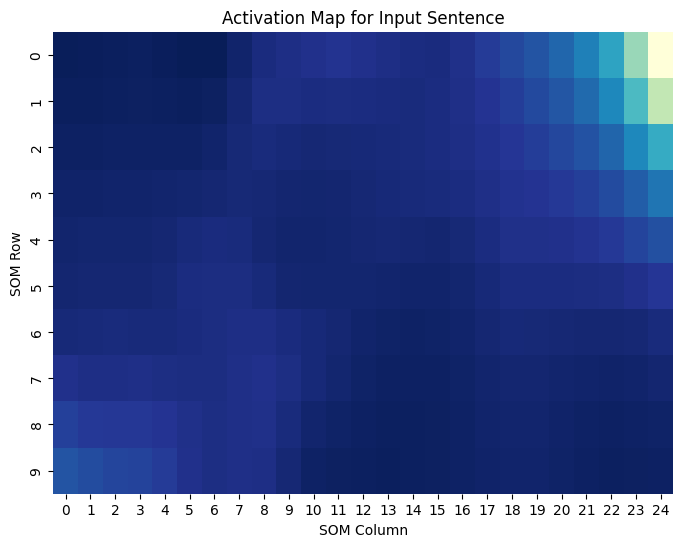

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_activation_map(activation_map, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(activation_map, cmap="YlGnBu", annot=False, cbar=False)
    plt.title(title)
    plt.xlabel("SOM Column")
    plt.ylabel("SOM Row")
    plt.show()

activation_map = activate(train_data, SOM, normalised_input_vector)
plot_activation_map(activation_map, "Activation Map for Input Sentence")


In [84]:
import pickle

with open('socialgroup_model.pkl', 'wb') as f:
    pickle.dump(SOM, f)